# Brent Oil Price - Exploratory Data Analysis


In [11]:
import sys
from pathlib import Path

ROOT = Path("..").resolve()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

from src.data_preprocessing import load_brent_data, calculate_returns, load_events_data
from src.time_series import adf_test, rolling_volatility
from src.visualization import *

setup_plotting_style()

In [12]:
# 1. Load Data
print("Loading data...")
df_prices = load_brent_data("../data/raw/BrentOilPrices.csv")
df_returns = calculate_returns(df_prices)
df_events = load_events_data("../data/events/key_events.csv")

print(f"Price data shape: {df_prices.shape}")
print(f"Date range: {df_prices['Date'].min()} to {df_prices['Date'].max()}")
print(f"Events count: {len(df_events)}")

Loading data...
Price data shape: (8360, 2)
Date range: 1987-05-20 00:00:00 to 2020-04-21 00:00:00
Events count: 24


In [13]:
# 2. Basic Statistics
print("\n=== Price Statistics ===")
price_stats = df_prices["Price"].describe()
print(price_stats)

print("\n=== Returns Statistics ===")
returns_stats = df_returns["Log_Returns"].describe()
print(returns_stats)


=== Price Statistics ===
count    8360.000000
mean       46.459669
std        32.504671
min         9.100000
25%        18.780000
50%        31.750000
75%        67.042500
max       143.950000
Name: Price, dtype: float64

=== Returns Statistics ===
count    8359.000000
mean       -0.000085
std         0.024876
min        -0.643699
25%        -0.011153
50%         0.000089
75%         0.011786
max         0.301613
Name: Log_Returns, dtype: float64


In [14]:
# 3. Stationarity Analysis
print("\n=== Stationarity Tests ===")

price_adf = adf_test(df_prices["Price"])
print(f"Price series - ADF Stat: {price_adf['adf_stat']:.4f}, p-value: {price_adf['p_value']:.4f}")
print(f"Price is {'stationary' if price_adf['is_stationary'] else 'non-stationary'}")

returns_adf = adf_test(df_returns["Log_Returns"])
print(f"\nLog returns - ADF Stat: {returns_adf['adf_stat']:.4f}, p-value: {returns_adf['p_value']:.4f}")
print(f"Log returns are {'stationary' if returns_adf['is_stationary'] else 'non-stationary'}")


=== Stationarity Tests ===


Price series - ADF Stat: -2.0187, p-value: 0.2785
Price is non-stationary

Log returns - ADF Stat: -12.6031, p-value: 0.0000
Log returns are stationary


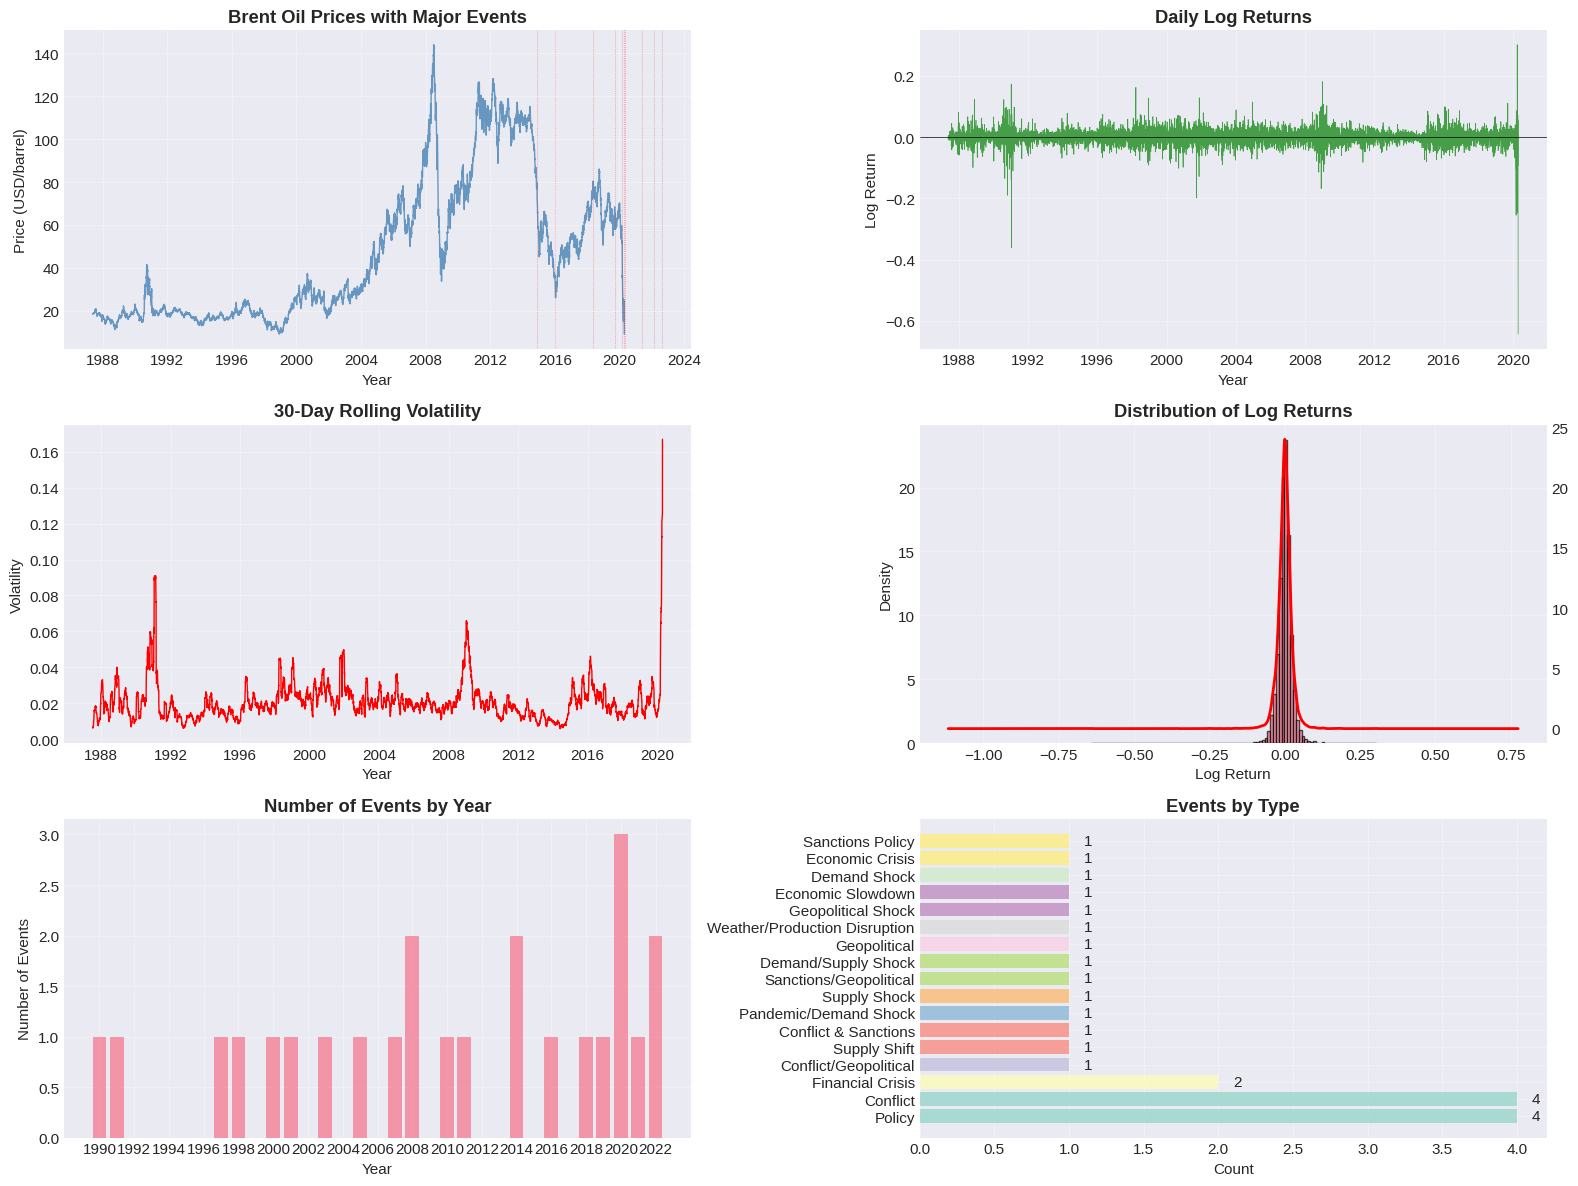

In [15]:
# 4. Create Comprehensive EDA Plots
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# 4.1 Price series with events
ax = axes[0, 0]
ax.plot(df_prices['Date'], df_prices['Price'], linewidth=1, alpha=0.8, color='steelblue')
for _, event in df_events.nlargest(10, 'Date').iterrows():
    ax.axvline(event['Date'], color='red', linestyle=':', alpha=0.5, linewidth=0.5)
ax.set_title('Brent Oil Prices with Major Events', fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Price (USD/barrel)')
ax.grid(True, alpha=0.3)

# 4.2 Log returns
ax = axes[0, 1]
ax.plot(df_returns['Date'], df_returns['Log_Returns'], linewidth=0.5, alpha=0.7, color='green')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title('Daily Log Returns', fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Log Return')
ax.grid(True, alpha=0.3)

# 4.3 Rolling volatility (30-day) - FIXED
ax = axes[1, 0]
df_returns['Volatility_30D'] = df_returns['Log_Returns'].rolling(window=30).std()
ax.plot(df_returns['Date'], df_returns['Volatility_30D'], linewidth=1, color='red')
ax.set_title('30-Day Rolling Volatility', fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Volatility')
ax.grid(True, alpha=0.3)

# 4.4 Returns distribution - FIXED
ax = axes[1, 1]
returns_data = df_returns['Log_Returns'].dropna()
ax.hist(returns_data, bins=100, edgecolor='black', alpha=0.7, density=True)
returns_data.plot(kind='kde', ax=ax, secondary_y=True, color='red', linewidth=2)
ax.set_title('Distribution of Log Returns', fontweight='bold')
ax.set_xlabel('Log Return')
ax.set_ylabel('Density')
ax.grid(True, alpha=0.3)

# 4.5 Events by year - FIXED
ax = axes[2, 0]
events_by_year = df_events['Date'].dt.year.value_counts().sort_index()
all_years = range(df_events['Date'].dt.year.min(), df_events['Date'].dt.year.max() + 1)
year_counts = [events_by_year.get(year, 0) for year in all_years]
ax.bar(all_years, year_counts, alpha=0.7)
ax.set_title('Number of Events by Year', fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Events')
ax.set_xticks(list(all_years)[::2])
ax.grid(True, alpha=0.3)

# 4.6 Events by type - FIXED
ax = axes[2, 1]
events_by_type = df_events['Event_Type'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(events_by_type)))
bars = ax.barh(list(events_by_type.index), events_by_type.values, alpha=0.7, color=colors)
ax.set_title('Events by Type', fontweight='bold')
ax.set_xlabel('Count')
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.1, bar.get_y() + bar.get_height()/2, f"{int(width)}", ha='left', va='center')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/eda_summary.png', dpi=150, bbox_inches='tight')
plt.show()


=== Time Series Decomposition ===


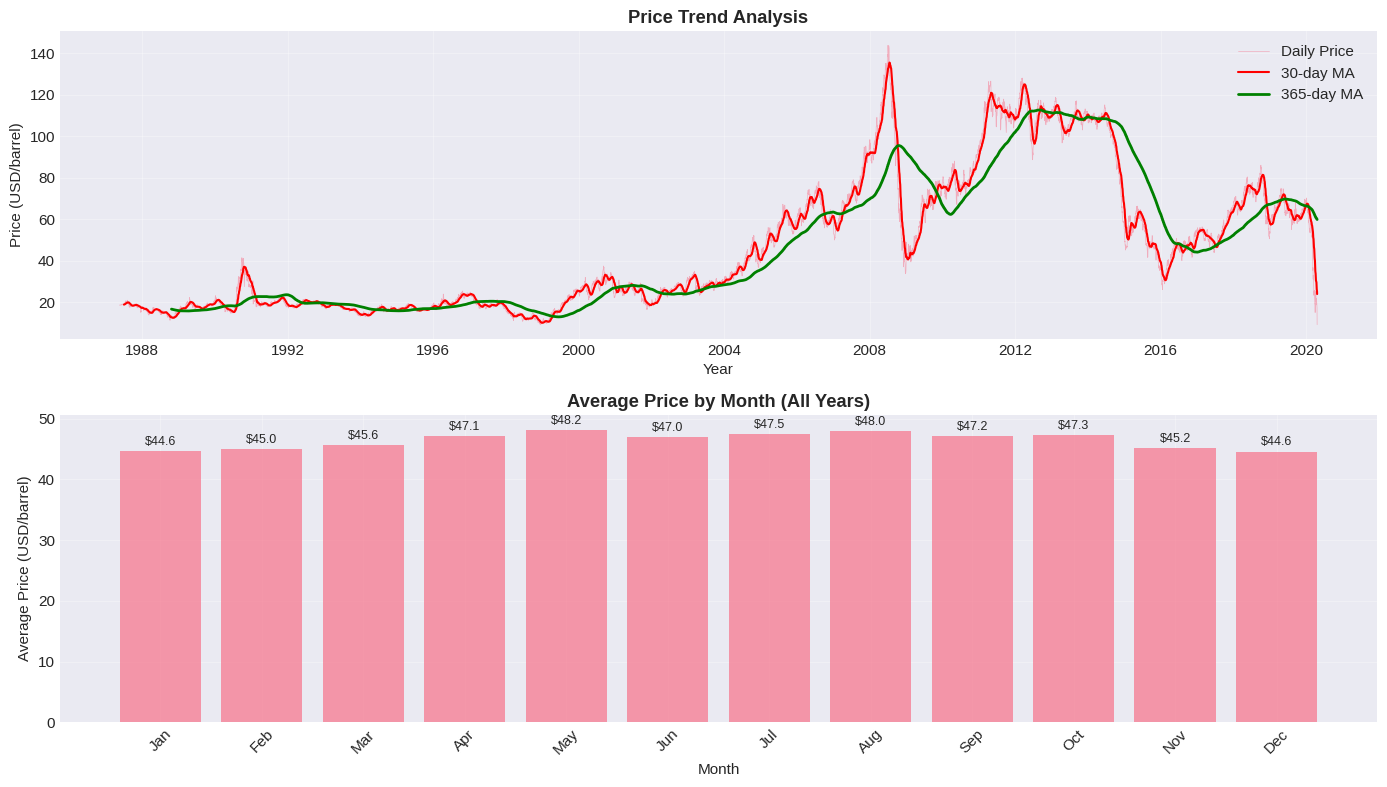

In [16]:
# 5. Time Series Decomposition (Trend, Seasonality, Residuals)
print("\n=== Time Series Decomposition ===")

df_prices['MA_30'] = df_prices['Price'].rolling(window=30).mean()
df_prices['MA_365'] = df_prices['Price'].rolling(window=365).mean()

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Trend analysis - FIXED: Only plot where we have moving averages
ax = axes[0]
ax.plot(df_prices['Date'], df_prices['Price'], linewidth=0.5, alpha=0.5, label='Daily Price')
ax.plot(df_prices['Date'], df_prices['MA_30'], linewidth=1.5, color='red', label='30-day MA')
ax.plot(df_prices['Date'], df_prices['MA_365'], linewidth=2, color='green', label='365-day MA')
ax.set_title('Price Trend Analysis', fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Price (USD/barrel)')
ax.legend()
ax.grid(True, alpha=0.3)

# Seasonality analysis (monthly averages) - FIXED
ax = axes[1]
monthly_avg = df_prices.groupby(df_prices['Date'].dt.month)['Price'].mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
bars = ax.bar(range(1, 13), monthly_avg.values, alpha=0.7)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(months, rotation=45)
ax.set_title('Average Price by Month (All Years)', fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Average Price (USD/barrel)')
for bar, month in zip(bars, months):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'${height:.1f}', ha='center', va='bottom', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/trend_seasonality.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# 6. Event Impact Preliminary Analysis
print("\n=== Preliminary Event Impact Analysis ===")

def analyze_event_impact(event_date, window_days=30):
    """Analyze price impact around an event."""
    start_date = event_date - timedelta(days=window_days)
    end_date = event_date + timedelta(days=window_days)
    mask = (df_prices['Date'] >= start_date) & (df_prices['Date'] <= end_date)
    event_data = df_prices[mask].copy()
    if len(event_data) > 0:
        pre_event = event_data[event_data['Date'] < event_date]
        post_event = event_data[event_data['Date'] > event_date]
        if len(pre_event) > 0 and len(post_event) > 0:
            pre_avg = pre_event['Price'].mean()
            post_avg = post_event['Price'].mean()
            pct_change = ((post_avg - pre_avg) / pre_avg) * 100
            return {
                'pre_avg': pre_avg,
                'post_avg': post_avg,
                'pct_change': pct_change,
                'window_days': window_days
            }
    return None

print("\nImpact of Selected Events (±30 days):")
top_events = df_events.nlargest(5, 'Date')
for _, event in top_events.iterrows():
    impact = analyze_event_impact(event['Date'])
    if impact:
        print(f"\n{event['Event_Title']} ({event['Date'].date()}):")
        print(f"  Pre-event avg: ${impact['pre_avg']:.2f}")
        print(f"  Post-event avg: ${impact['post_avg']:.2f}")
        print(f"  Change: {impact['pct_change']:+.2f}%")


=== Preliminary Event Impact Analysis ===

Impact of Selected Events (±30 days):

COVID-19 Lockdowns & Brent Crash (2020-04-20):
  Pre-event avg: $21.57
  Post-event avg: $9.12
  Change: -57.72%


In [18]:
# 7. Save EDA Summary
vol_30 = df_returns['Volatility_30D']
eda_summary = {
    'data_info': {
        'price_records': len(df_prices),
        'date_range': f"{df_prices['Date'].min().date()} to {df_prices['Date'].max().date()}",
        'total_days': (df_prices['Date'].max() - df_prices['Date'].min()).days,
        'events_count': len(df_events),
        'events_years': f"{df_events['Date'].min().year} to {df_events['Date'].max().year}"
    },
    'price_statistics': price_stats.to_dict(),
    'returns_statistics': returns_stats.to_dict(),
    'stationarity': {
        'price': price_adf,
        'log_returns': returns_adf
    },
    'volatility': {
        'avg_30d_vol': float(vol_30.mean()),
        'max_30d_vol': float(vol_30.max()),
        'vol_clusters': 'Present' if vol_30.std() > 0.5 else 'Moderate'
    }
}

import json
with open('../docs/eda_summary.json', 'w') as f:
    json.dump(eda_summary, f, indent=2, default=str)

print("\n=== EDA Complete ===")
print("Summary saved to: docs/eda_summary.json")
print("Plots saved to: docs/eda_summary.png and docs/trend_seasonality.png")


=== EDA Complete ===
Summary saved to: docs/eda_summary.json
Plots saved to: docs/eda_summary.png and docs/trend_seasonality.png
